# Combinatorial library: Construct ligands

The combinatorial library consists of fragment IDs and connecting bond IDs, which can be used to construct the described ligand based on the reduced fragment library.

- Fragment IDs (`fragment_ids`), e.g. `["B1_13", "SE_138", "GA_77", "AP_12"]` (`<subpocket>_<fragment index in subpocket pool>`)
- Bond IDs (`bond_ids`), e.g. `[["AP_9", "SE_6"], ["GA_14", "AP_10"], ["B1_8", "GA_13"]]`: Atom (`<subpocket>_<atom ID>`) pairs per fragment bond

Please find more information about the file format in `4_1_combinatorial_library_data.ipynb`.

__Note__: In this notebook, we showcase how the molecules described via fragment and bond indices the combinatorial library can be build into `rdkit` molecule objects. Please note that we show this molecule construction only for a small subset. If you would like to construct _all_ ligands, it might take time and storage. We offer a utility function that will loop over the library and store N (user-defined) molecules each in one SDF file each.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import ijson
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from kinfraglib import utils

In [3]:
HERE = Path(_dh[-1])
PATH_FRAGMENT_LIBRARY_REDUCED = HERE / '../../data/fragment_library_reduced/'
PATH_COMBINATORIAL_LIBRARY = HERE / '../../data/combinatorial_library/combinatorial_library_deduplicated.json'

## Fragment library

In [4]:
fragment_library = utils.read_fragment_library(PATH_FRAGMENT_LIBRARY_REDUCED)
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

## Combinatorial library

We use a generator to access the ligand metadata in `PATH_COMBINATORIAL_LIBRARY`. As an example, let's take a look at the first ligand's metadata in this file.

In [5]:
with open(PATH_COMBINATORIAL_LIBRARY, 'rb') as f:
    ligand_metadata_generator = ijson.items(f, 'item')
    ligand_metadata = next(ligand_metadata_generator)
    print(ligand_metadata)

{'bond_ids': [['AP_10', 'GA_14'], ['AP_9', 'SE_6'], ['GA_13', 'B1_8']], 'fragment_ids': ['B1_13', 'GA_77', 'SE_138', 'AP_12'], 'hba': 1, 'hbd': 1, 'mwt': 1, 'logp': 1, 'n_atoms': 36, 'chembl_exact': 0, 'chembl_most_similar': ['CHEMBL1603403', Decimal('0.52')], 'original_exact': 0, 'original_substructure': 0, 'inchi': 'InChI=1S/C27H21FN6O2/c1-16-21(27(36)31-32(16)2)12-24(35)33-11-10-20-23(33)9-8-19(25(20)28)22-14-30-34-15-18(13-29-26(22)34)17-6-4-3-5-7-17/h3-11,13-15H,12H2,1-2H3,(H,31,36)'}


## Construct ligands from combinatorial library

### Show first N ligands

#### Define function

In [6]:
def construct_first_n_ligands_from_combinatorial_library(
    path_combinatorial_library, 
    path_fragment_library, 
    n_first_ligands=20
):
    """
    Construct the first N ligands in the combinatorial library from the therein stored
    fragment and bond IDs (referring to fragments in the fragment library).
    
    Parameters
    ----------
    path_combinatorial_library : str or pathlib.Path
        Path to combinatorial library (json file).
    path_fragment_library : str or pathlib.Path
        Path to underlying fragment library (folder with sdf files per subpocket).
    n_first_ligands : int
        Number of first ligands to be constructed (default: 20)
        
    Returns
    -------
    list of rdkit.Chem.rdchem.Mol
        List of constructed ligands.
    """
    
    path_combinatorial_library = Path(path_combinatorial_library)
    path_fragment_library = Path(path_fragment_library)
    
    # Load fragment library
    fragment_library = utils.read_fragment_library(path_fragment_library)

    # Iterate over first N elements in combinatorial library
    ligand_metadata_list = []
    with open(path_combinatorial_library, 'rb') as f:
        ligand_metadata_generator = ijson.items(f, 'item')

        i = 0
        while i < n_first_ligands:
            ligand_metadata = next(ligand_metadata_generator)
            ligand_metadata_list.append(ligand_metadata)
            i += 1
            
    # Construct ligand based on 
    ligand_list = [
        utils.construct_ligand(ligand["fragment_ids"], ligand["bond_ids"], fragment_library) 
        for ligand in ligand_metadata_list
    ]
    
    return ligand_list

#### Construct and draw N (here: 20) first ligands.

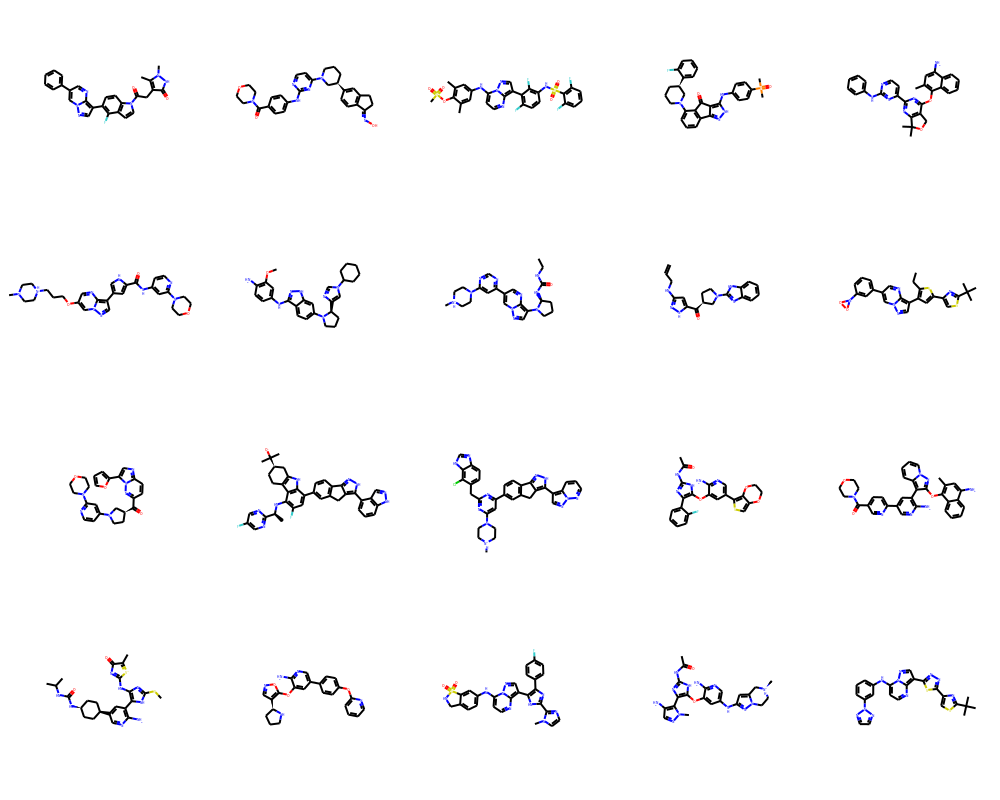

In [7]:
ligand_list = construct_first_n_ligands_from_combinatorial_library(
    PATH_COMBINATORIAL_LIBRARY, 
    PATH_FRAGMENT_LIBRARY_REDUCED, 
    n_first_ligands=20
)

Draw.MolsToGridImage(mols=ligand_list, molsPerRow=5)

### Construct all ligands and save to file(s)

#### Define function

In [8]:
def construct_and_save_ligands_from_combinatorial_library(
    path_combinatorial_library, 
    path_fragment_library, 
    path_output,
    n_first_ligands=None,
    n_ligands_per_sdf_file=20
):
    """
    Construct and save ligands in the combinatorial library from the therein stored
    fragment and bond IDs (referring to fragments in the fragment library).
    
    Parameters
    ----------
    path_combinatorial_library : str or pathlib.Path
        Path to combinatorial library (json file).
    path_fragment_library : str or pathlib.Path
        Path to underlying fragment library (folder with sdf files per subpocket).
    path_output : str or pathlib.Path
        Path to output folder.
    n_first_ligands : int
        Number of first ligands to be constructed (default: None).
    n_ligands_per_sdf_file : int
        Number of ligands to be stored in one sdf file (default: 20).
    """
    
    path_combinatorial_library = Path(path_combinatorial_library)
    path_fragment_library = Path(path_fragment_library)
    path_output = Path(path_output)
    
    # Load fragment library
    fragment_library = utils.read_fragment_library(path_fragment_library)
    
    # Iterate over elements in combinatorial library
    with open(PATH_COMBINATORIAL_LIBRARY, 'rb') as f:
        ligand_metadata_generator = ijson.items(f, 'item')
        
        # Initialize ligand metadata list
        ligand_metadata_list = []
        for i, ligand_metadata in enumerate(ligand_metadata_generator, 1):
            ligand_metadata_list.append(ligand_metadata)
            
            # If max. number of ligands per file reached
            if len(ligand_metadata_list) == n_ligands_per_sdf_file:
                # Construct and save ligands
                _construct_and_save_selected_ligands(
                    ligand_metadata_list, fragment_library, path_output, i
                )
                # Reinitialize ligand metadata list
                ligand_metadata_list = []

            # If max. number of ligands to process reached
            if i == n_first_ligands:
                # Construct and save remaining ligands
                _construct_and_save_selected_ligands(
                    ligand_metadata_list, fragment_library, path_output, i
                )
                # Break for-loop
                break
        
        # When for-loop is done, construct and save remaining ligands
        _construct_and_save_selected_ligands(
            ligand_metadata_list, fragment_library, path_output, i
        )

In [9]:
def _construct_and_save_selected_ligands(ligand_metadata_list, fragment_library, path_output, index):
    """
    Construct and save selected ligands.
    
    Parameters
    ----------
    ligand_metadata_list : list of dict
        Ligand metadata as dictionary with keys such as "fragment_ids" and "bond_ids"
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, kinase groups, and fragment RDKit molecules, (values) for each subpocket (key).
    path_output : str or pathlib.Path
        Path to output folder.
    index : int
        Index of last ligand in list (w.r.t. position in combinatorial library).
    """
    
    # Construct ligand
    ligand_list = [
        utils.construct_ligand(ligand["fragment_ids"], ligand["bond_ids"], fragment_library) 
        for ligand in ligand_metadata_list
    ]
    # Save ligands to file
    if len(ligand_list) > 0:
        with open(path_output / f'ligands{index}.sdf', 'w') as f:
            w = Chem.SDWriter(f)
            for mol in ligand_list:
                w.write(mol)
            w.close()

#### Construct and save example ligands

Add folder to `data/` where we will store the SDF files.

In [10]:
PATH_CONSTRUCTED_MOLECULES = HERE / "../../data/combinatorial_library_constructed"
PATH_CONSTRUCTED_MOLECULES.mkdir(parents=True, exist_ok=True)

Construct and save ligands: Example 20k ligands (10k ligands/sdf file) - runtime see below; ~30 MB per file.

In [11]:
%%time 
construct_and_save_ligands_from_combinatorial_library(
    PATH_COMBINATORIAL_LIBRARY, 
    PATH_FRAGMENT_LIBRARY_REDUCED, 
    PATH_CONSTRUCTED_MOLECULES,
    n_first_ligands=20000,
    n_ligands_per_sdf_file=10000
)

CPU times: user 56.6 s, sys: 269 ms, total: 56.8 s
Wall time: 56.9 s
